In [2]:
import re
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [4]:
word_to_index = {}
tag_to_index = {}
max_sentence_length = 0
word_count = {}
word_to_index['<PAD>'] = 0
tag_to_index['<UNK>'] = 0

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path = "/content/drive/My Drive/ColabNotebooks/NLP2024"

Got all senteces with padding and each sentence with pos tags

In [21]:
# This will provide each sentence with paddings <unk>
def process_dataset(dataset_file, p=2, s=3):
    sentences_list = []
    pos_list = []

    with open(dataset_file, 'r', encoding='utf-8') as f:
        sentence_tokens = []
        pos_tags = []

        for line in f:
            line = line.strip()

            if line.startswith('#'):
                sentence_tokens = []
                pos_tags = []
                continue
            elif line == '':
                # Append padding to the end of the sentence
                padded_sentence = ' '.join(['<PAD>'] * p) + ' ' + ' '.join(sentence_tokens) + ' ' + ' '.join(['<PAD>'] * s)
                padded_pos = ' '.join(['<UNK>'] * p + pos_tags + ['<UNK>'] * s)
                sentences_list.append(padded_sentence)
                pos_list.append(padded_pos)
                continue
            else:
                # New sentence begins
                token_attrs = line.split('\t')
                word_form = token_attrs[1]  # Word form of the token
                pos_tag = token_attrs[3]    # POS tag of the token
                sentence_tokens.append(word_form)
                pos_tags.append(pos_tag)
    return sentences_list, pos_list

In [22]:
def get_indices(sentences_list, pos_list, word_to_index, tag_to_index, max_sentence_length, word_count):
    # Process each sentence to tokenize the data
    for sentence_str, tag_str in zip(sentences_list, pos_list):
        # Tokenize the sentence into individual tokens
        tokens = sentence_str.split(' ')
        tags = tag_str.split(' ')
            # Word to index
        for word, tag in zip(tokens, tags):
            if word not in word_to_index:
                word_to_index[word] = len(word_to_index)
            word_count[word] = word_count.get(word, 0) + 1
        # Tag to index
            if tag not in tag_to_index:
                tag_to_index[tag] = len(tag_to_index)
        max_sentence_length = max(max_sentence_length, len(tokens))
    return word_to_index, tag_to_index, max_sentence_length, word_count

In [20]:
train_dataset = path + "/conllu/train.conllu"
test_dataset = path + "/conllu/test.conllu"
val_dataset = path + "/conllu/val.conllu"
train_sentece_list, train_pos_list = process_dataset(train_dataset, p= 2, s= 3)
test_sentece_list, test_pos_list = process_dataset(test_dataset, p= 2, s= 3)
val_sentece_list, val_pos_list = process_dataset(val_dataset, p= 2, s= 3)


sentences_list = train_sentece_list + test_sentece_list + val_sentece_list
pos_list = train_pos_list + test_pos_list + val_pos_list

# Split the data into sentences
word_to_index = {'<UNK>': 0}
tag_to_index = {'<UNK>': 0}
word_count = {'<UNK>': 1}
max_sentence_length = 0
# get all indices
word_to_index, tag_to_index, max_sentence_length, word_count = get_indices(sentences_list, pos_list, word_to_index, tag_to_index, max_sentence_length, word_count)

## Function for calculating embedding for all sentences

In [23]:
def PrepareEmbedding(sentence_dataset, pos_dataset, word_to_index, tag_to_index, max_sentence_length, word_count):
    token_embeddings = []
    labels_embedding = []
    for sentence_str, tag_str in zip(sentence_dataset, pos_dataset):
        # Tokenize the sentence into individual tokens
        tokens = sentence_str.split(' ')
        tags = tag_str.split(' ')
        one_sentence_token_embedding = []
        one_sentence_pos_embedding = []
        # Word to index
        for word, tag in zip(tokens, tags):
            if word in word_to_index:
                if word_count[word] < 2:
                    word_cur_idx = word_to_index['<UNK>']
                else:
                    word_cur_idx = word_to_index[word]
            else:
                word_cur_idx = word_to_index['<UNK>']
            # Tag to index
            if tag in tag_to_index:
                tag_cur_idx = tag_to_index[tag]
            else:
                tag_cur_idx = tag_to_index['<UNK>']
            one_sentence_token_embedding.append(word_cur_idx)
            one_sentence_pos_embedding.append(tag_cur_idx)
        # Pad sequences using PyTorch's pad_sequence function
        token_embeddings.append(one_sentence_token_embedding)
        labels_embedding.append(one_sentence_pos_embedding)
    return token_embeddings, labels_embedding

In [24]:
train_sentence_embeddings, train_pos_embeddings = PrepareEmbedding(train_sentece_list, train_pos_list, word_to_index, tag_to_index, max_sentence_length, word_count)
test_sentence_embeddings, test_pos_embeddings = PrepareEmbedding(test_sentece_list, test_pos_list, word_to_index, tag_to_index, max_sentence_length, word_count)
val_sentence_embeddings, val_pos_embeddings = PrepareEmbedding(val_sentece_list, val_pos_list, word_to_index, tag_to_index, max_sentence_length, word_count)
# It will save a lot of time

In [ ]:
train_sentence_embeddings

### Feed Forward netword

In [17]:
import numpy as np
# Step 1: Define the Model
class FFNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, p, s):
        super(FFNN, self).__init__()
        # Calculate the actual input size considering embedding dimensions
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear((p + s + 1) *embedding_dim , hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input tensor
        first = self.embedding(x)
        first = first.view(-1)
        out = self.fc1(first)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Define the number of steps after which to print the loss and accuracy
print_interval = 100

# Step 2: Define Loss Function
criterion = nn.CrossEntropyLoss()

# Step 3: Instantiate Model
vocab_size = len(word_to_index)
embedding_dim = 100  # Example dimension, adjust as needed
hidden_size = 64  # Example size, adjust as needed
output_size = len(tag_to_index)
p = 2
s = 3
model = FFNN(vocab_size, embedding_dim, hidden_size, output_size, p, s).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Example optimizer, adjust as needed

def train_model(model, criterion, optimizer, train_embeddings, train_pos_embeddings, print_interval, epoch):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    # Iterate over the training dataset
    for token_indices, pos_indices in zip(train_embeddings, train_pos_embeddings):
        token_indices = torch.LongTensor(token_indices).to(device)
        pos_indices = torch.LongTensor(pos_indices).to(device)
        # Create sliding window of size 6 and convert to tensors
        for i in range(p, len(token_indices) - s):
            window_tokens = token_indices[i-p:i+s+1]
            # window_tokens_tensor = torch.LongTensor(window_tokens).to(device)
            pos_tag = pos_indices[i]
            # creating one hot encoding for the pos tag
            # length should be the number of tags
            pos_tag_tensor = torch.zeros(len(tag_to_index)).to(device)
            pos_tag_tensor[pos_tag] = 1
            optimizer.zero_grad()
            outputs = model(window_tokens)  # Forward pass
            # Calculate loss
            loss = criterion(outputs, pos_tag_tensor)  # Compare outputs with true labels
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    return running_loss / len(train_embeddings)

def evaluate_model(model, criterion, val_embeddings, val_pos_embeddings):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0

    # Iterate over the validation dataset
    with torch.no_grad():
        for token_indices, pos_indices in zip(val_embeddings, val_pos_embeddings):
            # Create sliding window of size 6 and convert to tensors
            token_indices = torch.LongTensor(token_indices).to(device)
            pos_indices = torch.LongTensor(pos_indices).to(device)
            for i in range(p, len(token_indices) - s):
                window_tokens = token_indices[i-p:i+s+1]
                # window_tokens_tensor = torch.LongTensor(window_tokens).to(device)
                pos_tag = pos_indices[i]
                # creating one hot encoding for the pos tag
                # length should be the number of tags
                pos_tag_tensor = torch.zeros(len(tag_to_index)).to(device)
                pos_tag_tensor[pos_tag] = 1
                outputs = model(window_tokens)  # Forward pass
                # Calculate loss
                loss = criterion(outputs, pos_tag_tensor)  # Compare outputs with true labels
                running_loss += loss.item()

    return running_loss / len(val_embeddings)

def test_model(model, criterion, test_embeddings, test_pos_embeddings):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0

    # Iterate over the test dataset
    with torch.no_grad():
        for token_indices, pos_indices in zip(test_embeddings, test_pos_embeddings):
            # Create sliding window of size 6 and convert to tensors
            token_indices = torch.LongTensor(token_indices).to(device)
            pos_indices = torch.LongTensor(pos_indices).to(device)
            for i in range(p, len(token_indices) - s):
                window_tokens = token_indices[i-p:i+s+1]
                # window_tokens_tensor = torch.LongTensor(window_tokens)
                pos_tag = pos_indices[i]
                # creating one hot encoding for the pos tag
                # length should be the number of tags
                pos_tag_tensor = torch.zeros(len(tag_to_index)).to(device)
                pos_tag_tensor[pos_tag] = 1
                outputs = model(window_tokens)  # Forward pass
                # Calculate loss
                loss = criterion(outputs, pos_tag_tensor)  # Compare outputs with true labels
                running_loss += loss.item()

    return running_loss / len(test_embeddings)

# Number of epochs
num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training phase
    train_loss = train_model(model, criterion, optimizer, train_sentence_embeddings, train_pos_embeddings, print_interval, epoch+1)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    train_losses.append(train_loss)
    # Validation phase
    val_loss = evaluate_model(model, criterion, val_sentence_embeddings, val_pos_embeddings)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}")
    val_losses.append(val_loss)

# Testing phase
test_loss = test_model(model, criterion, test_sentence_embeddings, test_pos_embeddings)
print(f"Test Loss: {test_loss:.4f}")



Epoch [1/10], Train Loss: 1.9518
Epoch [1/10], Validation Loss: 3.7658
Epoch [2/10], Train Loss: 0.9409
Epoch [2/10], Validation Loss: 2.5182
Epoch [3/10], Train Loss: 0.7257
Epoch [3/10], Validation Loss: 2.6724
Epoch [4/10], Train Loss: 0.6457
Epoch [4/10], Validation Loss: 2.8541
Epoch [5/10], Train Loss: 0.5448
Epoch [5/10], Validation Loss: 4.0716
Epoch [6/10], Train Loss: 0.5319
Epoch [6/10], Validation Loss: 3.8796
Epoch [7/10], Train Loss: 0.5396
Epoch [7/10], Validation Loss: 4.5263
Epoch [8/10], Train Loss: 0.5054
Epoch [8/10], Validation Loss: 4.5604
Epoch [9/10], Train Loss: 0.4874
Epoch [9/10], Validation Loss: 5.2129
Epoch [10/10], Train Loss: 0.5248
Epoch [10/10], Validation Loss: 4.9388
Test Loss: 4.7031


In [19]:
FFNNmodel_path = path +  '/FFNNmodel.pth'
# Save the model
torch.save(model.state_dict(), FFNNmodel_path)

In [ ]:
def evaluateFFNN(model, sentences, word_to_index, tag_to_index, device):
    sentence_token = sentences.split(' ')
    embedded_sentence = [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence_token]
    embedded_sentence = torch.tensor(embedded_sentence, dtype=torch.long)
    token = []
    tag = []
    for i in range(2, len(embedded_sentence) - 3):
        input = embedded_sentence[i-2:i+3 + 1].to(device)
        output = model(input)
        token.append(sentence_token[i])
        tag.append(list(tag_to_index.keys())[list(tag_to_index.values()).index(torch.argmax(output).item())])

    for i in range(len(token)):
        print(f"{token[i]}: {tag[i]}")


sentence = "where is the beset place to go for a vacation"
padded_sentence = ' '.join(['<PAD>'] * p) + ' ' + ''.join(sentence) + ' ' + ' '.join(['<PAD>'] * s)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FFNN(vocab_size, embedding_dim, hidden_size, output_size, p, s)
model_param = torch.load('FFNNmodel.pth')
model.load_state_dict(model_param)

evaluateFFNN(model, padded_sentence, word_to_index, tag_to_index, device)


Data prepare

In [ ]:
X_train, y_train = process_data(train_data, word_to_index, tag_to_index, max_sentence_length, word_count)
X_val, y_val = process_data(val_data, word_to_index, tag_to_index, max_sentence_length, word_count)
X_test, y_test = process_data(test_data, word_to_index, tag_to_index, max_sentence_length, word_count)




# Step 2: Create PyTorch DataLoaders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#### Create PyTorch datasets and data loaders for training data. This allows efficient batching and shuffling of data.

In [ ]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define Model

X_train.shape[1] is used to specify the input size of the neural network model.     X_train.shape[1] accesses the second element of the shape tuple, which represents the number of features or input dimensions in your dataset. In the example (1000, 50), X_train.shape[1] would be 50.

Sending X_train.shape[1] as the input_size parameter to the FFNN constructor ensures that the input layer of your neural network has the correct number of neurons to accommodate the input features of your dataset.

In [ ]:
# Step 3: Define Loss Function and Optimizer
model = FFNN(input_size=X_train.shape[1], hidden_size=128, output_size=y_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Step 4: Training Loop

In [ ]:
for epoch in range(1000):  # Adjust number of epochs as needed
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
index_to_tag = {v: k for k, v in tag_to_index.items()}

# Question2 : 2 Recurrent Neural Network POS Tagging
Design and implement a model which uses Recurrent Neural Networks (Vanilla
RNN, LSTM, or GRU) for POS Tagging. The model should take the embeddings for all tokens in a sentence and output the corresponding POS tags in
sequence.
- For Example: In the sentence "An apple a day keeps the doctor away",
 the model takes the embeddings for
- ["An", "apple", "a", "day", "keeps", "the","doctor", "away"] and
 outputs the POS tags for all the words in the sentence
- ["DET", "NOUN", "DET", "NOUN", "VERB", "DET", "NOUN", "ADV"]

Step1 : Count all words and postags and provide them a index value

- Doing it for all 3 datasets train, validation and test-dataset

In [37]:
# Selecting sentences for training
train_sentece_list_train = train_sentece_list[:8]
train_pos_list_train = train_pos_list[:8]

# Selecting sentences for validation
val_sentece_list_val = val_sentece_list[:4]
val_pos_list_val = val_pos_list[:4]

# Selecting sentences for testing
test_sentece_list_test = test_sentece_list[:4]
test_pos_list_test = test_pos_list[:4]

# Prepare embeddings for training, validation, and testing datasets
train_sentence_embeddings, train_pos_embeddings = PrepareEmbedding(train_sentece_list_train, train_pos_list_train, word_to_index, tag_to_index, max_sentence_length, word_count)
val_sentence_embeddings, val_pos_embeddings = PrepareEmbedding(val_sentece_list_val, val_pos_list_val, word_to_index, tag_to_index, max_sentence_length, word_count)
test_sentence_embeddings, test_pos_embeddings = PrepareEmbedding(test_sentece_list_test, test_pos_list_test, word_to_index, tag_to_index, max_sentence_length, word_count)


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, input_sentence):
        embeds = self.word_embeddings(input_sentence)
        lstm_out, _ = self.lstm(embeds.view(len(input_sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(input_sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


In [26]:
vocab_size = len(word_to_index)
tagset_size = len(tag_to_index)
embedding_dim = 100
hidden_dim = 128

In [27]:
def trainModel(model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(10):
        model.zero_grad()
        # ?PrepareEmbedding
        for sentence, tags in zip(train_sentence_embeddings, train_pos_embeddings):
            sentence_in = torch.LongTensor(sentence).to(device)
            targets = torch.LongTensor(tags).to(device)
            tag_scores = model(sentence_in)
            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()
def testModel(model, test_sentence_embeddings, test_pos_embeddings):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients during testing
        for sentence, tags in zip(test_sentence_embeddings, test_pos_embeddings):
            sentence_in = torch.LongTensor(sentence).to(device)
            targets = torch.LongTensor(tags).to(device)
            tag_scores = model(sentence_in)
            _, predicted = torch.max(tag_scores, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy
model = LSTMTagger(embedding_dim, hidden_dim, len(word_to_index), len(tag_to_index)).to(device)
trainModel(model)
testModel(model, test_sentence_embeddings, test_pos_embeddings)


Test Accuracy: 84.14%


0.8414300736067297

In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

def evaluate_model(model, data_sentence_embeddings, data_pos_embeddings):
    model.eval()  # Set the model to evaluation mode
    all_targets = []
    all_predicted = []
    with torch.no_grad():  # No need to track gradients during evaluation
        for sentence, tags in zip(data_sentence_embeddings, data_pos_embeddings):
            sentence_in = torch.LongTensor(sentence).to(device)
            targets = torch.LongTensor(tags).to(device)
            tag_scores = model(sentence_in)
            _, predicted = torch.max(tag_scores, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predicted)
    recall = recall_score(all_targets, all_predicted, average='micro')
    precision = precision_score(all_targets, all_predicted, average='micro')
    f1 = f1_score(all_targets, all_predicted, average='micro')

    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Generate confusion matrix
    confusion_mat = confusion_matrix(all_targets, all_predicted)
    print("Confusion Matrix:")
    print(confusion_mat)

    return accuracy, recall, precision, f1, confusion_mat

# Evaluation on validation set
print("Validation Set Evaluation:")
val_accuracy, val_recall, val_precision, val_f1, val_confusion_mat = evaluate_model(model, val_sentence_embeddings, val_pos_embeddings)

# Evaluation on test set
print("Test Set Evaluation:")
test_accuracy, test_recall, test_precision, test_f1, test_confusion_mat = evaluate_model(model, test_sentence_embeddings, test_pos_embeddings)


Validation Set Evaluation:
Evaluation Metrics:
Accuracy: 87.34%
Recall: 0.8734
Precision: 0.8734
F1 Score: 0.8734
Confusion Matrix:
[[2860    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0  365    1   45    1    0    1    1    0    0    0    0    0    0
     0]
 [   0    0  226    1    3    1    2   31    0    0    0    2    0    0
     0]
 [   0   13    0  522    5    6   11    7    0    3    0    0    0    1
     0]
 [   0    1    5    7  880    9  167   28   13   28    0    5    0    0
     0]
 [   0   28    0    1   52 1268   49    9    3    1    0    1    3    0
     0]
 [   0    9    1    8  108   26 1290   54   15   27    0   13    0    0
     0]
 [   0    2    6    5   23    7   51  492    8   50    0    9    0    0
     0]
 [   0    0    0    0   24    5   14    3   83    0    0    2    0    0
     0]
 [   0    0    1    2   17    3   37    4    1  133    0   29    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0  107    0    0  

Saving

Validation Set Evaluation:
Evaluation Metrics:
Accuracy: 87.34%
Recall: 0.8734
Precision: 0.8734
F1 Score: 0.8734
Confusion Matrix:
[[2860    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0  365    1   45    1    0    1    1    0    0    0    0    0    0
     0]
 [   0    0  226    1    3    1    2   31    0    0    0    2    0    0
     0]
 [   0   13    0  522    5    6   11    7    0    3    0    0    0    1
     0]
 [   0    1    5    7  880    9  167   28   13   28    0    5    0    0
     0]
 [   0   28    0    1   52 1268   49    9    3    1    0    1    3    0
     0]
 [   0    9    1    8  108   26 1290   54   15   27    0   13    0    0
     0]
 [   0    2    6    5   23    7   51  492    8   50    0    9    0    0
     0]
 [   0    0    0    0   24    5   14    3   83    0    0    2    0    0
     0]
 [   0    0    1    2   17    3   37    4    1  133    0   29    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0  107    0    0  

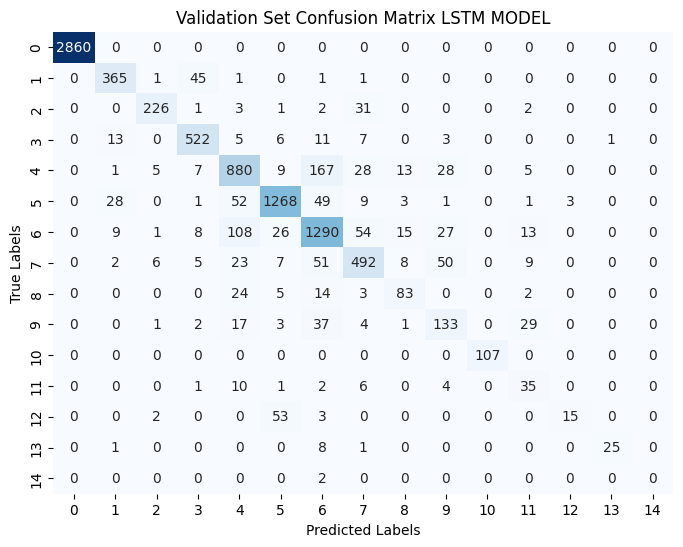

Test Set Evaluation:
Evaluation Metrics:
Accuracy: 87.39%
Recall: 0.8739
Precision: 0.8739
F1 Score: 0.8739
Confusion Matrix:
[[2930    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0  340    1   46    2    1    1    0    1    0    0    0    0    0]
 [   0    0  212    0    1    0    9   29    1    1    0    3    0    0]
 [   0    6    2  473    6    1   12    9    2    1    0    0    0    0]
 [   1    3    4   10  877   10  155   45    7   42    1   11    0    0]
 [   0   39    0    3   43 1284   50    7    4    3    0    0    1    0]
 [   0    2    2    4  110   25 1316   50   17   24    1   15    0    1]
 [   0    0    4    1   28    8   44  474    2   59    0    9    0    0]
 [   0    1    0    0   37    4    8    3   72    1    0    1    0    0]
 [   0    0    0    3   11    1   30    4    3  142    0   26    0    0]
 [   0    0    0    0    2    0    0    1    0    0  106    0    0    0]
 [   0    1    0    0    8    0   10    2    1    6    0   48    0    0

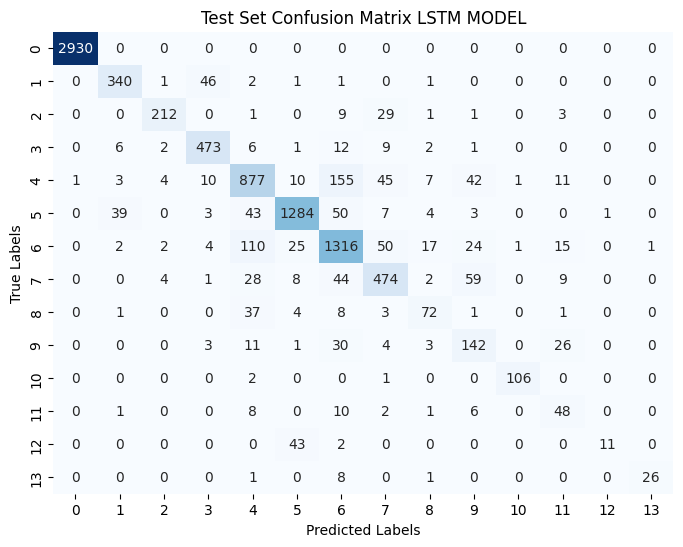

In [28]:
# Define a function to plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(confusion_mat, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Evaluation on validation set
print("Validation Set Evaluation:")
val_accuracy, val_recall, val_precision, val_f1, val_confusion_mat = evaluate_model(model, val_sentence_embeddings, val_pos_embeddings)
plot_confusion_matrix(val_confusion_mat, title='Validation Set Confusion Matrix LSTM MODEL')

# Evaluation on test set
print("Test Set Evaluation:")
test_accuracy, test_recall, test_precision, test_f1, test_confusion_mat = evaluate_model(model, test_sentence_embeddings, test_pos_embeddings)
plot_confusion_matrix(test_confusion_mat, title='Test Set Confusion Matrix LSTM MODEL')

In [28]:
FFNNmodel_path = path +  'lstmModel.pth'
# Save the model
torch.save(model.state_dict(), FFNNmodel_path)

In [29]:
def evaluate(sentence):
    sentence = re.sub('[^ A-Za-z0-9]+', '', sentence).split()
    tokenized_sent = []
    for word in sentence:
        if word in word_to_index:
            tokenized_sent.append(word_to_index[word])
        else:
            tokenized_sent.append(word_to_index['<UNK>'])

    inputs = torch.tensor(tokenized_sent, dtype=torch.long, device=device)
    output = model(inputs)
    for i in range(len(sentence)):
        print(sentence[i]+"    "+index_to_tag[torch.argmax(output[i]).item()])
index_to_tag = {v: k for k, v in tag_to_index.items()}
evaluate(" An apple a day")

An    NOUN
apple    NOUN
a    DET
day    NOUN


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")


device(type='cuda')